In [191]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import sklearn
import os
import subprocess
import json
import sys
import csv
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from matplotlib.pyplot import subplots
import csv


In [87]:
#file names, should try to automate more
VCF_FILE_NAME = 'ERR6634978-ERR6635032-7030.vcf.gz' #this needs to be changed as well 
VCF_PATH='/mnt/storage7/lwang/trial_tb_philippines/data/processed/seqtk/freebayesVCF'
VCF_FILE_PATH = os.path.join(VCF_PATH, VCF_FILE_NAME)
# JSON_FILE_PATH = os.path.join(VCF_PATH, 'results/ERR6634978-ERR6635032-8020.results.json') #for the time being, change the file names here

# with open(JSON_FILE_PATH, 'r') as f:
#     json_labelling = json.load(f)

with open('ROAO_proportion.csv', 'w') as f:
    subprocess.run(['bcftools', 'query', '-f', '[%POS,%RO,%AO\n]', VCF_FILE_PATH], shell=False, stdout=f, text=True)

#count how many column there is in the ROAO_proportion.csv file this is needed in order to read the csv in a a panda dataframe

with open('ROAO_proportion.csv', 'r') as f:

    data = []
    num_col=0
    for line in f:
        data_line = line.rstrip().split('\n')
        data_line = data_line[0].split(',')
        data_line = [int(i) for i in data_line]
        if len(data_line) > num_col:
            num_col = len(data_line)
        data.append(data_line)

    #print(num_col) #outputing the length of column in the dataframe
    num_RO = num_col - 1
    #print(num_RO)


In [88]:
df = pd.read_csv('ROAO_proportion.csv', names=range(num_col)) #doesn't include the 4th colum
df.fillna(value=0, inplace=True)

df[2] = df.iloc[:, 2:].sum(axis=1)
df = df.iloc[:,:3]
df[df.shape[1]] = None #create an additional column here as a empty column of zero, this column is for the drug resistance info
df_np = df.to_numpy()

In [178]:
def graph_ratio(name, prediction, df_np, output1=0, output2=1):

    df_np_temp = df_np[:,0:3]
    df_np_temp = np.insert(df_np_temp, 3, prediction, axis=1)

    number_of_labels0 = len(prediction[prediction==output1])
    number_of_labels1 = len(prediction[prediction==output2])
    labels = np.unique(prediction)
    print('Unique output values', labels)
    print('ref to alt ratio', number_of_labels0/(number_of_labels0+number_of_labels1),':',number_of_labels1/(number_of_labels1+number_of_labels0))


    fig, ax = subplots(nrows=1, ncols=3, figsize=(20, 7))

    ax[0].scatter(df_np_temp[:,1], df_np_temp[:,2], c=df_np_temp[:,3], s=15, cmap='spring', alpha=0.2)
    ax[0].set_title(f"{name}_two strains")

    ax[1].scatter(df_np_temp[df_np_temp[:,3]==output1][:,1], df_np_temp[df_np_temp[:,3]==output1][:,2], c='b', s=15, cmap='bwr', alpha=0.2)
    ax[1].set_title(f"{name}_starin0")
    # ax[1].set_xlim(0,800)
    # ax[2].set_ylim(0,600)


    ax[2].scatter(df_np_temp[df_np_temp[:,3]==output2][:,1], df_np_temp[df_np_temp[:,3]==output2][:,2], c='r', s=15, cmap='bwr', alpha=0.2)
    ax[2].set_title(f"{name}_strain2")

<h1>One variable

In [90]:
df_np

array([[1302, 146, 44.0, None],
       [1977, 0, 195.0, None],
       [2532, 128, 69.0, None],
       ...,
       [4408920, 108, 30.0, None],
       [4410386, 163, 80.0, None],
       [4411016, 120, 61.0, None]], dtype=object)

Unique output values [0 1]
ref to alt ratio 0.6617120836774016 : 0.3382879163225984


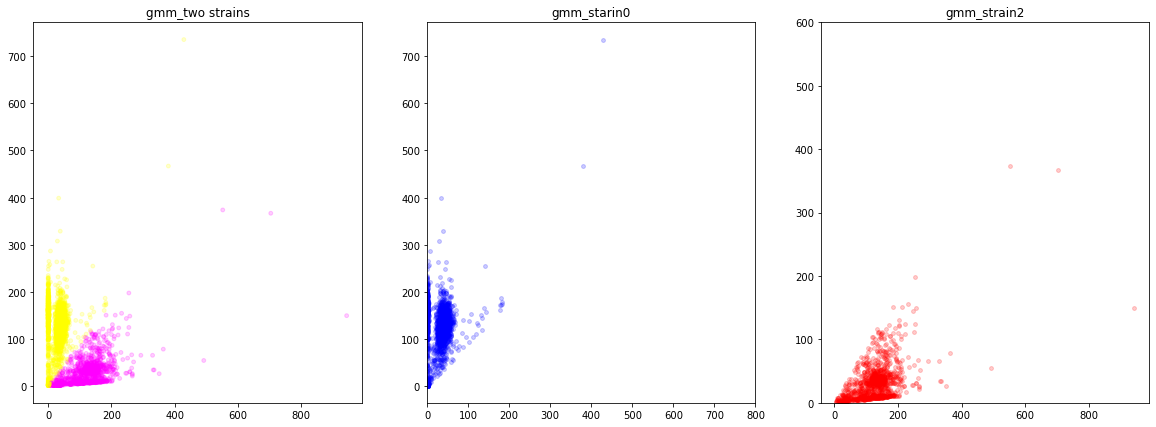

In [78]:
df_np_nz = []

for x in df_np:
    if x[1]==0 and x[2]==0:
        pass
    elif x[2]==0:
        pass
    else:
        df_np_nz.append(x)

df_np_nz = np.array(df_np_nz)

sum_ = df_np_nz[:,1] + df_np_nz[:,2]
freq = df_np_nz[:,2] / sum_
np.array(freq)

gm = GaussianMixture(n_components=2, random_state=0, covariance_type="full")
#gm.fit(df_np[:,freq])
gm.fit(freq.reshape(-1,1)) #one variable version


predictions = []

for x in freq:
    output = gm.predict(np.array(x).reshape(-1,1))
    predictions.append(output)

predictions_list = []
for x in predictions: #turn prediction which is a list of arrays of single values into a normal list
    predictions_list.append(x[0])

df_np_nz = np.insert(df_np_nz, 3, predictions_list, axis=1)

graph_ratio('gmm', df_np_nz[:,3],df_np_nz, output1=1, output2=0 )


In [15]:
df_np_nz[:,1]+df_np_nz[:,2]

array([190.0, 195.0, 197.0, ..., 138.0, 243.0, 181.0], dtype=object)

In [16]:
df_np_nz

array([[1302, 146, 44.0, 1, None],
       [1977, 0, 195.0, 0, None],
       [2532, 128, 69.0, 1, None],
       ...,
       [4408920, 108, 30.0, 1, None],
       [4410386, 163, 80.0, 1, None],
       [4411016, 120, 61.0, 1, None]], dtype=object)

<h1>Depth filter

In [183]:
#file names, should try to automate more
VCF_FILE_NAME = 'ERR6634978-ERR6635032-2080.vcf.gz' #this needs to be changed as well 
VCF_PATH='/mnt/storage7/lwang/trial_tb_philippines/data/processed/seqtk/freebayesVCF'
VCF_FILE_PATH = os.path.join(VCF_PATH, VCF_FILE_NAME)
# JSON_FILE_PATH = os.path.join(VCF_PATH, 'results/ERR6634978-ERR6635032-8020.results.json') #for the time being, change the file names here

# with open(JSON_FILE_PATH, 'r') as f:
#     json_labelling = json.load(f)

with open('ROAO_proportion_DP.csv', 'w') as f:
    subprocess.run(['bcftools', 'query', '-f', '[%POS,%RO,%AO,%DP\n]', VCF_FILE_PATH], shell=False, stdout=f, text=True)

#count how many column there is in the ROAO_proportion.csv file this is needed in order to read the csv in a a panda dataframe
import csv

with open('ROAO_proportion_DP.csv', 'r') as f:
    data = []
    num_col=0
    for line in f:
        data_line = line.rstrip().split('\n')
        data_line = data_line[0].split(',')
        data_line = [int(i) for i in data_line]
        if len(data_line) > num_col:
            num_col = len(data_line)
        data.append(data_line)

    #print(num_col) #outputing the length of column in the dataframe
    num_RO = num_col - 1
    #print(num_RO)

    df = pd.read_csv('ROAO_proportion_DP.csv', names=range(num_col)) #doesn't include the 4th colum
    df.fillna(value=0, inplace=True)

    df[2] = df.iloc[:, 2:3].sum(axis=1)
    df = df.iloc[:,:4]
    df[df.shape[1]] = None #create an additional column here as a empty column of zero, this column is for the drug resistance info
    df_np = df.to_numpy()

mean: 155.59647674098542 
std: 66.3976275444414
skew 3.2455647658163462
kurt 46.91308296653922


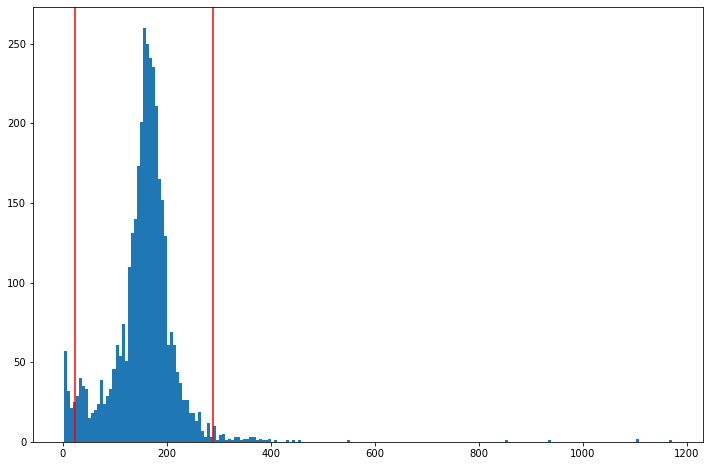

In [184]:
fig, ax= plt.subplots(figsize=(12, 8), ncols=1, nrows=1)
mean = df[3].mean()
std = df[3].std()
upper_limit = mean+(std*2)
lower_limit = mean-(std*2)
ax = plt.hist(df[3], bins=200)
ax = plt.axvline(upper_limit, color='r')
ax = plt.axvline(lower_limit, color='r')

print('mean:',mean, '\nstd:',std)
print('skew',df[3].skew())
print('kurt',df[3].kurt())

ERR6634978-ERR6635032-2080.vcf.gz
Unique output values [0 1]
ref to alt ratio 0.33352651405389744 : 0.6664734859461026


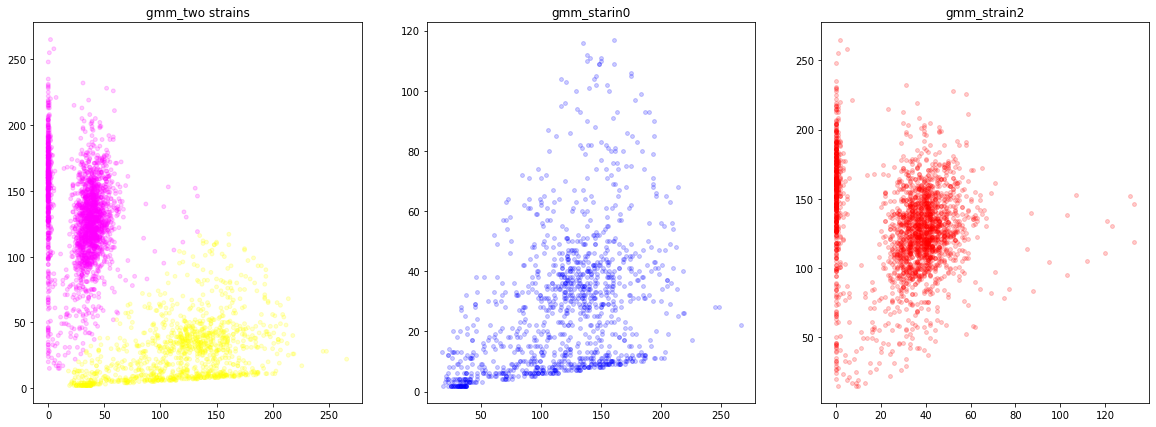

In [186]:
df_np_nz = []

for x in df_np:
    if x[1]==0 and x[2]==0:
        pass
    elif x[2]==0:
        pass
    elif x[3] > upper_limit or x[3] < lower_limit:
        pass
    else:
        df_np_nz.append(x)

df_np_nz = np.array(df_np_nz)

sum_ = df_np_nz[:,1] + df_np_nz[:,2]
freq = df_np_nz[:,2] / sum_
np.array(freq)

gm = GaussianMixture(n_components=2, random_state=0, covariance_type="full")
#gm.fit(df_np[:,freq])
gm.fit(freq.reshape(-1,1)) #one variable version


predictions = []

for x in freq:
    output = gm.predict(np.array(x).reshape(-1,1))
    predictions.append(output)

predictions_list = []
for x in predictions: #turn prediction which is a list of arrays of single values into a normal list
    predictions_list.append(x[0])

df_np_nz = np.insert(df_np_nz, 3, predictions_list, axis=1)

print(VCF_FILE_NAME)
graph_ratio('gmm', df_np_nz[:,3],df_np_nz, output1=1, output2=0 )


<h1>new_exclusion.bed reads removed

In [225]:
#file names, should try to automate more
VCF_FILE_NAME = 'ERR6634978-ERR6635032-1090.vcf.gz' #this needs to be changed as well 
VCF_PATH='/mnt/storage7/lwang/trial_tb_philippines/data/processed/seqtk/freebayesVCF'
VCF_FILE_PATH = os.path.join(VCF_PATH, VCF_FILE_NAME)
# JSON_FILE_PATH = os.path.join(VCF_PATH, 'results/ERR6634978-ERR6635032-8020.results.json') #for the time being, change the file names here

# with open(JSON_FILE_PATH, 'r') as f:
#     json_labelling = json.load(f)

with open('ROAO_proportion_DP.csv', 'w') as f:
    subprocess.run(['bcftools', 'query', '-f', '[%POS,%RO,%AO,%DP\n]', VCF_FILE_PATH], shell=False, stdout=f, text=True)

#count how many column there is in the ROAO_proportion.csv file this is needed in order to read the csv in a a panda dataframe
import csv

with open('ROAO_proportion_DP.csv', 'r') as f:
    data = []
    num_col=0
    for line in f:
        data_line = line.rstrip().split('\n')
        data_line = data_line[0].split(',')
        data_line = [int(i) for i in data_line]
        if len(data_line) > num_col:
            num_col = len(data_line)
        data.append(data_line)

    #print(num_col) #outputing the length of column in the dataframe
    num_RO = num_col - 1
    #print(num_RO)

    df = pd.read_csv('ROAO_proportion_DP.csv', names=range(num_col)) #doesn't include the 4th colum
    df.fillna(value=0, inplace=True)

    df[2] = df.iloc[:, 2:3].sum(axis=1)
    df = df.iloc[:,:4]
    df[df.shape[1]] = None #create an additional column here as a empty column of zero, this column is for the drug resistance info
    df_np = df.to_numpy()
     
with open('new_exclusion.bed', 'r') as f:

    exclusion = []
    num_col=0
    for line in f:
        data_line = line.rstrip().split('\n')
        data_line = data_line[0].split('\t')
        data_line = data_line[1:]
        data_line = [int(i) for i in data_line]
        exclusion.append(data_line)

Unique output values [0 1]
ref to alt ratio 0.7559886317498985 : 0.2440113682501015


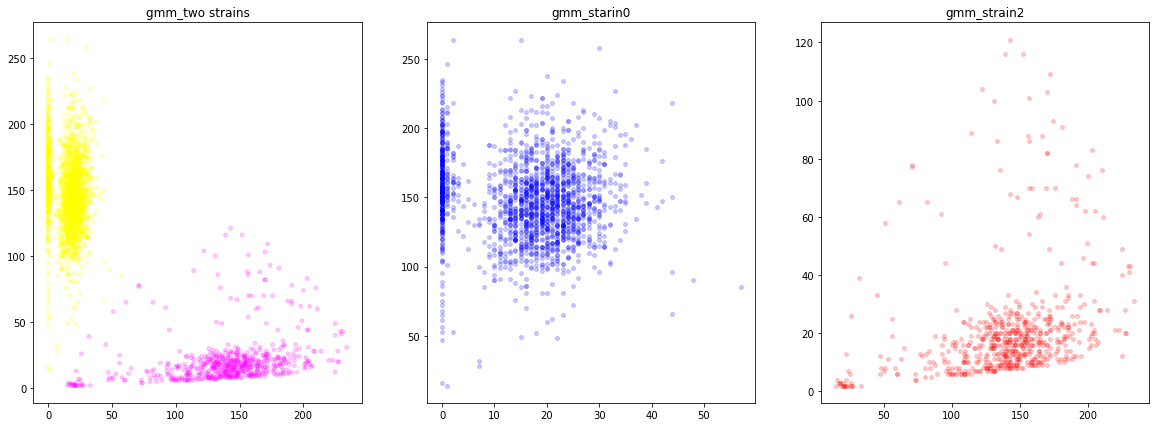

In [226]:
mean = df[3].mean()
std = df[3].std()
upper_limit = mean+(std*2)
lower_limit = mean-(std*2)
# fig, ax= plt.subplots(figsize=(12, 8), ncols=1, nrows=1)
# ax = plt.hist(df[3], bins=200)
# ax = plt.axvline(upper_limit, color='r')
# ax = plt.axvline(lower_limit, color='r')

# print('mean:',mean, '\nstd:',std)
# print('skew',df[3].skew())
# print('kurt',df[3].kurt())

df_np = np.hstack((df_np, np.zeros((df_np.shape[0], 1), dtype=df_np.dtype))) #creating an additional coloumn for the exclusion value

df_np_nz = []

for e, x in enumerate(df_np):
    for i in exclusion:
        if x[0] <= i[1] and x[0] >= i[0]:
            df_np[e,5]=0
            break
        else:
            df_np[e,5]=1

for x in df_np:
    if x[5]==0:
        pass
    elif x[1]==0 and x[2]==0:
        pass
    elif x[2]==0:
        pass
    elif x[3] > upper_limit or x[3] < lower_limit:
        pass

    else:
        df_np_nz.append(x)

df_np_nz = np.array(df_np_nz)

sum_ = df_np_nz[:,1] + df_np_nz[:,2]
freq = df_np_nz[:,2] / sum_
np.array(freq)

gm = GaussianMixture(n_components=2, random_state=0, covariance_type="full")
#gm.fit(df_np[:,freq])
gm.fit(freq.reshape(-1,1)) #one variable version

predictions = []

for x in freq:
    output = gm.predict(np.array(x).reshape(-1,1))
    predictions.append(output)

predictions_list = []
for x in predictions: #turn prediction which is a list of arrays of single values into a normal list
    predictions_list.append(x[0])

df_np_nz = np.insert(df_np_nz, 3, predictions_list, axis=1)

graph_ratio('gmm', df_np_nz[:,3],df_np_nz, output1=1, output2=0 )


In [211]:
# def test_ratio(df_np_nz):
#     with open('new_exclusion.bed', 'r') as f:
#         exclusion = []
#         num_col=0
#         for line in f:
#             data_line = line.rstrip().split('\n')
#             data_line = data_line[0].split('\t')
#             data_line = data_line[1:]
#             data_line = [int(i) for i in data_line]
#             exclusion.append(data_line)

#     VCF_PATH='/mnt/storage7/lwang/trial_tb_philippines/data/processed/seqtk/freebayesVCF'
#     JSON_FILE_PATH='/mnt/storage7/lwang/trial_tb_philippines/data/processed/seqtk/freebayesVCF/results'
#     NAME_FILE='/mnt/storage7/lwang/trial_tb_philippines/data/seqtk/sample_name.txt'

#     with open(NAME_FILE, 'r') as f:
#         sample_list = [line.rstrip('\n') for line in f]

#     sample_list_json=[]
#     for i,x in enumerate(sample_list):
#         x = list(x)
#         x.append('.results.json')
#         string = ''.join([letter for letter in x] )
#         sample_list_json.append(string)
            
#     ratio = []
#     for i in sample_list_json:
#         temp = i.split('-')
#         ratio.append(temp[2])
        
#     ratio1=[]
#     for i in ratio:
#         temp = i.split('.')
#         ratio1.append(temp[0])

#     ratio = ratio1

#     sample_list_vcf=[]
#     for i,x in enumerate(sample_list):
#         x = list(x)
#         x.append('.vcf.gz')
#         string = ''.join([letter for letter in x] )
#         sample_list_vcf.append(string)

#     for i, e in zip(sample_list_vcf, ratio):
#         VCF_FILE = os.path.join(VCF_PATH, i)


#         with open('ROAO_proportion_DP.csv', 'w') as f:
#             subprocess.run(['bcftools', 'query', '-f', '[%POS,%RO,%AO,%DP\n]', VCF_FILE], shell=False, stdout=f, text=True)

#         #count how many column there is in the ROAO_proportion.csv file this is needed in order to read the csv in a a panda dataframe


#         with open('ROAO_proportion_DP.csv', 'r') as f:
#             data = []
#             num_col=0
#             for line in f:
#                 data_line = line.rstrip().split('\n')
#                 data_line = data_line[0].split(',')
#                 data_line = [int(i) for i in data_line]
#                 if len(data_line) > num_col:
#                     num_col = len(data_line)
#                 data.append(data_line)

#             #print(num_col) #outputing the length of column in the dataframe
#             num_RO = num_col - 1
#             #print(num_RO)

#             df = pd.read_csv('ROAO_proportion_DP.csv', names=range(4)) #doesn't include the 4th colum
#             df.fillna(value=0, inplace=True)

#             df[2] = df.iloc[:, 2:3].sum(axis=1)
#             df = df.iloc[:,:4]
#             df[df.shape[1]] = None #create an additional column here as a empty column of zero, this column is for the drug resistance info
#             df_np = df.to_numpy()
        
#         mean = df[3].mean()
#         std = df[3].std()
#         upper_limit = mean+(std*2)
#         lower_limit = mean-(std*2)
#         # fig, ax= plt.subplots(figsize=(12, 8), ncols=1, nrows=1)
#         # ax = plt.hist(df[3], bins=200)
#         # ax = plt.axvline(upper_limit, color='r')
#         # ax = plt.axvline(lower_limit, color='r')

#         # print('mean:',mean, '\nstd:',std)
#         # print('skew',df[3].skew())
#         # print('kurt',df[3].kurt())

#         sum_ = df_np_nz[:,1] + df_np_nz[:,2]
#         freq = df_np_nz[:,2] / sum_
#         np.array(freq)

#         gm = GaussianMixture(n_components=2, random_state=0, covariance_type="full")
#         #gm.fit(df_np[:,freq])
#         gm.fit(freq.reshape(-1,1)) #one variable version

#         predictions = []

#         for x in freq:
#             output = gm.predict(np.array(x).reshape(-1,1))
#             predictions.append(output)

#         predictions_list = []
#         for x in predictions: #turn prediction which is a list of arrays of single values into a normal list
#             predictions_list.append(x[0])

#         df_np_temp = df_np_nz[:,0:3]
#         df_np_temp = np.insert(df_np_temp, 3, predictions_list, axis=1)

#         number_of_labels0 = len(df_np_temp[df_np_temp[:,3]==0])
#         number_of_labels1 = len(df_np_temp[df_np_temp[:,3]==1])
#         labels = np.unique(df_np_temp[:,3])
#         print(e)
#         print('Unique output values', labels)
#         print('ref to alt ratio', number_of_labels0/(number_of_labels0+number_of_labels1),':',number_of_labels1/(number_of_labels1+number_of_labels0))

#         # fig, ax = subplots(nrows=1, ncols=3, figsize=(20, 7))

#         # ax[0].scatter(df_np_temp[:,1], df_np_temp[:,2], c=df_np_temp[:,3], s=15, cmap='spring', alpha=0.2)
#         # ax[0].set_title(f"{name}_two strains")

#         # ax[1].scatter(df_np_temp[df_np_temp[:,3]==output1][:,1], df_np_temp[df_np_temp[:,3]==output1][:,2], c='b', s=15, cmap='bwr', alpha=0.2)
#         # ax[1].set_title(f"{name}_starin0")
#         # # ax[1].set_xlim(0,800)
#         # # ax[2].set_ylim(0,600)

#         # ax[2].scatter(df_np_temp[df_np_temp[:,3]==output2][:,1], df_np_temp[df_np_temp[:,3]==output2][:,2], c='r', s=15, cmap='bwr', alpha=0.2)
#         # ax[2].set_title(f"{name}_strain2")

<h1>K Near neighbour